# Web Scraping and Introductory Data Analysis

Welcome to Homework 0, where we will delve into web scraping and perform an introductory data analysis. This homework will be a hands-on exercise that will help you become familiar with the process of extracting data from websites and conducting basic statistical analysis. 

## Objectives

By the end of this homework, you will be able to:

1. Set up a Python environment with the necessary libraries for web scraping and data analysis.
2. Write a web scraping script using Beautiful Soup and Selenium to collect data from a website.
3. Sample from the collected dataset and compare the statistics of the sample and the population.
   
## Tasks

1. **Environment Setup**: Install the required libraries such as Beautiful Soup, Selenium, pandas, numpy, matplotlib, and seaborn.

2. **Web Scraping**: Write a script to scrape transaction data from [Etherscan.io](https://etherscan.io/txs). Use Selenium to interact with the website and Beautiful Soup to parse the HTML content.

3. **Data Sampling**: Once the data is collected, create a sample from the dataset. Compare the sample statistics (mean and standard deviation) with the population statistics.


## Deliverables

1. A Jupyter notebook with all the code and explanations.
2. A detailed report on the findings, including the comparison of sample and population statistics.
Note: You can include the report in your notebook.

## Getting Started

Begin by setting up your Python environment and installing the necessary libraries. Then, proceed with the web scraping task, ensuring that you handle any potential issues such as rate limiting. Once you have the data, move on to the data sampling and statistical analysis tasks. 

Remember to document your process and findings in the Jupyter notebook, and to include visualizations where appropriate to illustrate your results. <br>
Good luck, and happy scraping!

## Data Collection (Etherscan)

In this section, we will use web scraping to gather transaction data from the Ethereum blockchain using the Etherscan block explorer. Our objective is to collect transactions from the **last 10 blocks** on Ethereum.

To accomplish this task, we will employ web scraping techniques to extract the transaction data from the Etherscan website. The URL we will be targeting for our data collection is:

[https://etherscan.io/txs](https://etherscan.io/txs)

### Steps

1. **Navigate to the URL**: Use Selenium to open the Etherscan transactions page in a browser.

2. **Locate the Transaction Data**: Identify the HTML elements that contain the transaction data for the specified block range.

3. **Extract the Data**: Write a script to extract the transaction details e.g. Hash, Method, Block, etc.

4. **Handle Pagination**: If the transactions span multiple pages, implement pagination handling to navigate through the pages and collect all relevant transaction data.

5. **Store the Data**: Save the extracted transaction data into a structured format, such as a CSV file or a pandas DataFrame, for further analysis.

### Considerations

- **Rate Limiting**: Be mindful of the website's rate limits to avoid being blocked. Implement delays between requests if necessary.
- **Dynamic Content**: The Etherscan website may load content dynamically. Ensure that Selenium waits for the necessary elements to load before attempting to scrape the data.
- **Data Cleaning**: After extraction, clean the data to remove any inconsistencies or errors that may have occurred during the scraping process.

### Resources

- [Beautiful Soup Documentation](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
- [Selenium Documentation](https://selenium-python.readthedocs.io/)
- [Pandas Documentation](https://pandas.pydata.org/docs/)
- [Ethereum](https://ethereum.org/en/)

## Install & import necessary Libraries

In [12]:
import importlib

# Check if Selenium is installed
if importlib.util.find_spec("selenium") is None:
    # Install Selenium
    !pip install selenium

# Check if BeautifulSoup (bs4) is installed
if importlib.util.find_spec("bs4") is None:
    # Install BeautifulSoup (bs4)
    !pip install beautifulsoup4

from selenium.webdriver.common.by import By
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
# from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
# import seaborn as sns
import time
import random

## Data Scraping

In [13]:
# Step 1: Navigate to the main page URL

domain = "https://etherscan.io"
homepage_url = domain + "/txs"
driver = webdriver.Chrome()
driver.get(homepage_url)

print("SUCCESS: Navigation to etherscan URL!")

# Step 2: Locate the Transaction Data

wait = WebDriverWait(driver, 10)    # Wait for the table to load (dynamic content consideration)
wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'table')))

# Extract the latest transaction's block number
transaction_table = driver.find_element(By.CLASS_NAME, 'table')
latest_transaction = transaction_table.find_element(By.XPATH, "//tbody/tr[1]")
latest_block_number = latest_transaction.find_element(By.XPATH, "./td[4]/a").text

print("SUCCESS: Latest block number is acquired!\n")

# Set the number of latest blocks needed to be scraped
target_block_count = 10
transaction_data = []

# Step 3: Extract the Data
# Step 4: Handle Pagination

for counter in range(target_block_count):
    # Navigate to the URL that a block's data is recorded
    block_number = int(latest_block_number) - counter
    query_string = "?block=" + str(block_number)
    current_block_url = homepage_url + query_string
    driver.get(current_block_url)
    
    print("SUCCESS: Navigation to block number " + str(counter + 1) + "'s URL!")

    while True:    # Continue scraping data until all block data is scraped from multiple pages
        wait = WebDriverWait(driver, 10)    # Wait for the table to load (dynamic content consideration)
        wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'table')))
    
        # Locate the transaction data table and its rows
        table = driver.find_element(By.CLASS_NAME, 'table')
        rows = table.find_elements(By.XPATH, "//tbody/tr")

        for row in rows:    # Extracting relevant columns using xpath of elements containing the actual data
            Txn_hash = row.find_element(By.XPATH, "./td[2]/div/span/a").text
            Method = row.find_element(By.XPATH, "./td[3]/span").text
            Block = row.find_element(By.XPATH, "./td[4]/a").text
            Age = row.find_element(By.XPATH, "./td[6]/span").text
            From = row.find_element(By.XPATH, "./td[8]/div/a").text
            To = row.find_element(By.XPATH, "./td[10]/div/a[1]").text
            Value = row.find_element(By.XPATH, "./td[11]/span").text
            Txn_Fee = row.find_element(By.XPATH, "./td[12]").text
            
            # Append the data to the database
            transaction_data.append({'Txn_Hash':Txn_hash, 'Method':Method, 'Block':Block, 'Age':Age, 'From':From, 'To':To, 'Value':Value, 'Txn_Fee': Txn_Fee})
    
        # Navigate to next page if there is one
        pagination_panel = driver.find_element(By.CLASS_NAME, 'pagination')
        if "disabled" not in pagination_panel.find_element(By.XPATH, ".//li[4]").get_attribute("class"):
            next_page_button = pagination_panel.find_element(By.XPATH, ".//li[4]/a")
            time.sleep(random.uniform(1, 3))    # Add a random delay between 1 and 3 seconds to consider rate limiting
            next_page_button.click()
        else:
            break   # All of the block's data is scraped. Move on to the next block.
            
        time.sleep(random.uniform(1, 3))    # Add a random delay between 1 and 3 seconds to consider rate limiting
    
    print("SUCCESS: Data of block number " + str(counter + 1) + " is scraped!")
    
# Step 5: Store the Data

# Convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(transaction_data)
# Save the raw DataFrame to a CSV file
df.to_csv('raw_ethereum_transactions.csv', index=False)

print("\nSUCCESS: Raw scraped data is saved!")

# Close the browser
driver.quit()

SUCCESS: Navigation to etherscan URL!
SUCCESS: Latest block number is acquired!
SUCCESS: Navigation to block number 1's URL!
SUCCESS: Data of block number 1 is scraped!
SUCCESS: Navigation to block number 2's URL!
SUCCESS: Data of block number 2 is scraped!
SUCCESS: Navigation to block number 3's URL!
SUCCESS: Data of block number 3 is scraped!
SUCCESS: Navigation to block number 4's URL!
SUCCESS: Data of block number 4 is scraped!
SUCCESS: Navigation to block number 5's URL!
SUCCESS: Data of block number 5 is scraped!
SUCCESS: Navigation to block number 6's URL!
SUCCESS: Data of block number 6 is scraped!
SUCCESS: Navigation to block number 7's URL!
SUCCESS: Data of block number 7 is scraped!
SUCCESS: Navigation to block number 8's URL!
SUCCESS: Data of block number 8 is scraped!
SUCCESS: Navigation to block number 9's URL!
SUCCESS: Data of block number 9 is scraped!
SUCCESS: Navigation to block number 10's URL!
SUCCESS: Data of block number 10 is scraped!

SUCCESS: Raw scraped data i

## Data Analysis

Now that we have collected the transaction data from Etherscan, the next step is to perform conduct an initial analysis. This task will involve the following steps:

1. **Load the Data**: Import the collected transaction data into a pandas DataFrame.

2. **Data Cleaning**: Clean the data by converting data types, removing any irrelevant information, and handling **duplicate** values.

3. **Statistical Analysis**: Calculate the mean and standard deviation of the population. Evaluate these statistics to understand the distribution of transaction values. The analysis and plotting will be on **Txn Fee** and **Value**.

4. **Visualization**: This phase involves the creation of visual representations to aid in the analysis of transaction values. The visualizations include:
    - A histogram for each data column, which provides a visual representation of the data distribution. The selection of bin size is crucial and should be based on the data's characteristics to ensure accurate representation. Provide an explanation on the bin size selection!
    - A normal distribution plot fitted alongside the histogram to compare the empirical distribution of the data with the theoretical normal distribution.
    - A box plot and a violin plot to identify outliers and provide a comprehensive view of the data's distribution.

### Deliverables

The project aims to deliver the following deliverables:

- A refined pandas DataFrame containing the transaction data, which has undergone thorough cleaning and is ready for analysis.
- A simple statistical analysis evaluating the population statistics, offering insights into the distribution of transaction values and fees.
- A set of visualizations showcasing the distribution of transaction values for the population. These visualizations include histograms, normal distribution plots, box plots, and violin plots, each serving a specific purpose in the analysis.

### Getting Started

The project starts with the importing of transaction data into a pandas DataFrame, setting the stage for data manipulation and analysis. Subsequent steps involve the cleaning of the data to ensure its quality and reliability. Followed by the calculation of population statistics. Finally, a series of visualizations are created to visually analyze the distribution of transaction values and fees.

## Install & import necessary libraries

In [14]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

## Data Cleaning

In [15]:
# Function to convert wei (a unit of Ethereum cryptocurrency) to ether
def wei_to_eth(wei):
    return wei / 10**18
  
# Step 1: Load the Data
    
# Load the CSV file into a DataFrame
df = pd.read_csv('raw_ethereum_transactions.csv')

# Step 2: Data Cleaning

# Remove duplicate rows from the DataFrame
df.drop_duplicates(inplace=True)

# Drop the useless columns from the DataFrame
df = df.drop(['Txn_Hash', 'Block', 'Age', 'From', 'To'], axis=1)

# Fill missing values with a specific value
df.fillna({'Value': 0, 'Txn_Fee': 0, 'Method': 'other'}, inplace=True)

# Create a new column 'Method_Category' with default value 'other'
df['Method_Category'] = 'Other'

# Define conditions for each category and update the 'Method_Category' accordingly
df.loc[df['Method'].str.lower().str.startswith('transfer'), 'Method_Category'] = 'Transfer'
df.loc[df['Method'].str.lower().str.startswith('0x'), 'Method_Category'] = 'Unidentified'
df.loc[df['Method'].str.lower().str.startswith('approve'), 'Method_Category'] = 'Approve'
df.loc[df['Method'].str.lower().str.startswith('execute'), 'Method_Category'] = 'Execute'
df.loc[df['Method'].str.lower().str.startswith('swap'), 'Method_Category'] = 'Swap'

# Drop the original 'Method' column since it's not needed anymore
df = df.drop('Method', axis=1)

# Rename the new 'Method_Category' column to 'Method'
df.rename(columns={'Method_Category': 'Method'}, inplace=True)

# Convert wei values to eth values
df['Value'] = df['Value'].apply(lambda x: wei_to_eth(int(x.split()[0])) if 'wei' in x else x)

# Convert Value & Txn_Fee columns to a numeric type
df['Value'] = df['Value'].str.replace('ETH' , '')   # Remove ETH from the value string
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
df['Txn_Fee'] = pd.to_numeric(df['Txn_Fee'], errors='coerce')

# Make a copy of the DataFrame and drop transactions with 'Value' == 0 and save to a CSV file
df_without_zeros = df.copy()
df_without_zeros = df_without_zeros.drop(df_without_zeros[df_without_zeros['Value'] == 0].index)
df_without_zeros.to_csv('clean_ethereum_transactions_without_zeros.csv', index=False)

# Calculate the interquartile range (IQR) for Value column
# Q1 = df['Value'].quantile(0.25)
# Q3 = df['Value'].quantile(0.75)
# IQR = Q3 - Q1

# Calculate max upper & lower whisker reach
# Max_Lower_Whisker_Reach = Q1 - 1.5 * IQR
# Max_Upper_Whisker_Reach = Q3 + 1.5 * IQR
# 
# print("Q1:", Q1)
# print("Q3:", Q3)
# print("IQR:", IQR)
# print("Max Lower Whisker Reach:", Max_Lower_Whisker_Reach)
# print("Max Upper Whisker Reach:", Max_Upper_Whisker_Reach)

# Save the clean DataFrame to a CSV file
df.to_csv('clean_ethereum_transactions.csv', index=False)

print("SUCCESS: Clean data is saved!")


SUCCESS: Clean data is saved!


## Data Analysis

### Statistical Analysis

In [16]:
# Step 3: Statistical Analysis

# Calculate statistical data for the 'Value' column (including 0 values)
Value_with0_stats = df[['Value']].agg(['mean', 'median', 'std', 'count']).transpose()

# Calculate statistical data for the 'Value' column (excluding 0 values)
Value_without0_stats = df_without_zeros[['Value']].agg(['mean', 'median', 'std', 'count']).transpose()

# Calculate statistical data for the 'Txn_Fee' column
Txn_Fee_stats = df[['Txn_Fee']].agg(['mean', 'median', 'std', 'count']).transpose()

# Merge all statistical data into one dataframe
merged_stats = pd.concat([Value_with0_stats, Value_without0_stats, Txn_Fee_stats], keys=['Full Dataset with 0:', 'Excluding 0 Values:', 'Full Dataset with 0:'])

# Rename the column headers
merged_stats.columns = ['Mean', 'Median', 'Standard Deviation', 'Count']

print("----------------------------------------------------------------------------------------")
print("                            Ungrouped Statistical Analysis                              ")
print("----------------------------------------------------------------------------------------")
print(merged_stats)

print("\nSUCCESS: Ungrouped Statistical Analysis conducted!")

# Group by 'Method' and calculate previous statistical calculations
Group_Value_with0_stats = df.groupby('Method')[['Value']].agg(['mean', 'median', 'std', 'count'])
Group_Value_without0_stats = df_without_zeros.groupby('Method')[['Value']].agg(['mean', 'median', 'std', 'count'])
Group_Txn_Fee_stats = df.groupby('Method')[['Txn_Fee']].agg(['mean', 'median', 'std', 'count'])

# Rename the column headers
Group_Value_with0_stats.columns = ['Mean', 'Median', 'Standard Deviation', 'Count']
Group_Value_without0_stats.columns = ['Mean', 'Median', 'Standard Deviation', 'Count']
Group_Txn_Fee_stats.columns = ['Mean', 'Median', 'Standard Deviation', 'Count']

print("----------------------------------------------------------------------------------------")
print("                             Grouped Statistical Analysis                               ")
print("----------------------------------------------------------------------------------------")
print("--> Grouped analysis for Value (Full Dataset with 0):\n")
print(Group_Value_with0_stats)
print("----------------------------------------------------------------------------------------")
print("--> Grouped analysis for Value (Excluding 0 Values):\n")
print(Group_Value_without0_stats)
print("----------------------------------------------------------------------------------------")
print("--> Grouped analysis for Txn_Fee (Full Dataset with 0):\n")
print(Group_Txn_Fee_stats)

print("\nSUCCESS: Grouped Statistical Analysis conducted!")

----------------------------------------------------------------------------------------
                            Ungrouped Statistical Analysis                              
----------------------------------------------------------------------------------------
                                  Mean    Median  Standard Deviation   Count
Full Dataset with 0: Value    0.365192  0.000000            3.188763  1636.0
Excluding 0 Values:  Value    0.785091  0.080734            4.641652   761.0
Full Dataset with 0: Txn_Fee  0.006791  0.002729            0.017582  1640.0

SUCCESS: Ungrouped Statistical Analysis conducted!
----------------------------------------------------------------------------------------
                             Grouped Statistical Analysis                               
----------------------------------------------------------------------------------------
--> Grouped analysis for Value (Full Dataset with 0):

                  Mean    Median  Standard Deviatio

### Visualization

### Histogram Plots

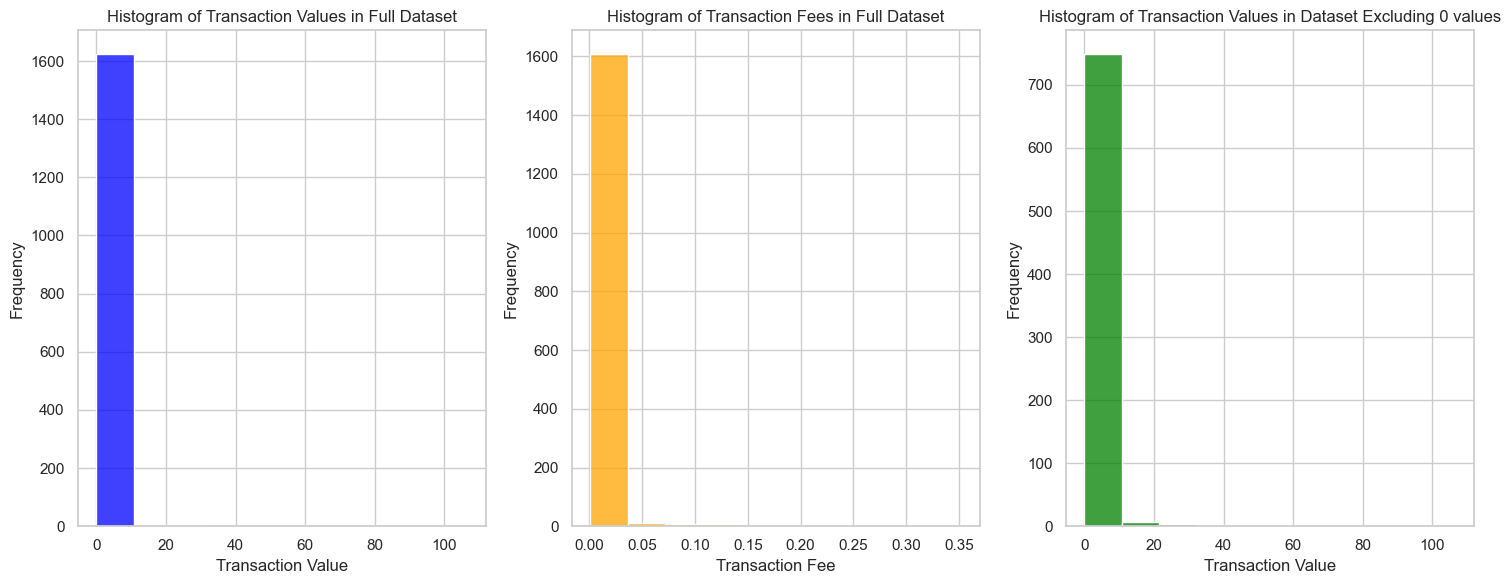

In [17]:
# Set the style for the plot
sns.set(style="whitegrid")

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

# Plot the histogram for 'Value' in full dataset
sns.histplot(data=df, x='Value', bins=10, color='blue', ax=axes[0])
axes[0].set_xlabel('Transaction Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Transaction Values in Full Dataset')

# Plot the histogram for 'Txn_Fee' in full dataset
sns.histplot(data=df, x='Txn_Fee', bins=10, color='orange', ax=axes[1])
axes[1].set_xlabel('Transaction Fee')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Transaction Fees in Full Dataset')

# Plot the histogram for 'Value' in dataset excluding 0 values
sns.histplot(data=df_without_zeros, x='Value', bins=10, color='green', ax=axes[2])
axes[2].set_xlabel('Transaction Value')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Histogram of Transaction Values in Dataset Excluding 0 values')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

# Box plot for 'Value' and 'Txn_Fee' grouped by 'Method'
# sns.boxplot(x='Method', y='Value', data=df, showfliers=False, palette='Blues')
# sns.boxplot(x='Method', y='Txn_Fee', data=df, showfliers=False, palette='Oranges')
# 
# plt.title('Box Plot of Value and Txn_Fee by Method')
# plt.ylabel('Value')
# plt.show()

# # Create a figure and axis for the plots
# fig, axs = plt.subplots(2, 1, figsize=(10, 8))
# 
# # Plot histogram for 'Value' column
# axs[0].hist(df['Value'], bins=100, color='skyblue', edgecolor='black')
# axs[0].set_title('Histogram of Value')
# axs[0].set_xlabel('Value')
# axs[0].set_ylabel('Frequency')
# 
# # Plot histogram for 'Txn fee' column
# axs[1].hist(df['Txn_Fee'], bins=30, color='salmon', edgecolor='black')
# axs[1].set_title('Histogram of Txn fee')
# axs[1].set_xlabel('Txn_Fee')
# axs[1].set_ylabel('Frequency')
# 
# # Adjust layout
# plt.tight_layout()
# 
# # Display the histograms
# plt.show()

### Logarithmic Histogram Plots

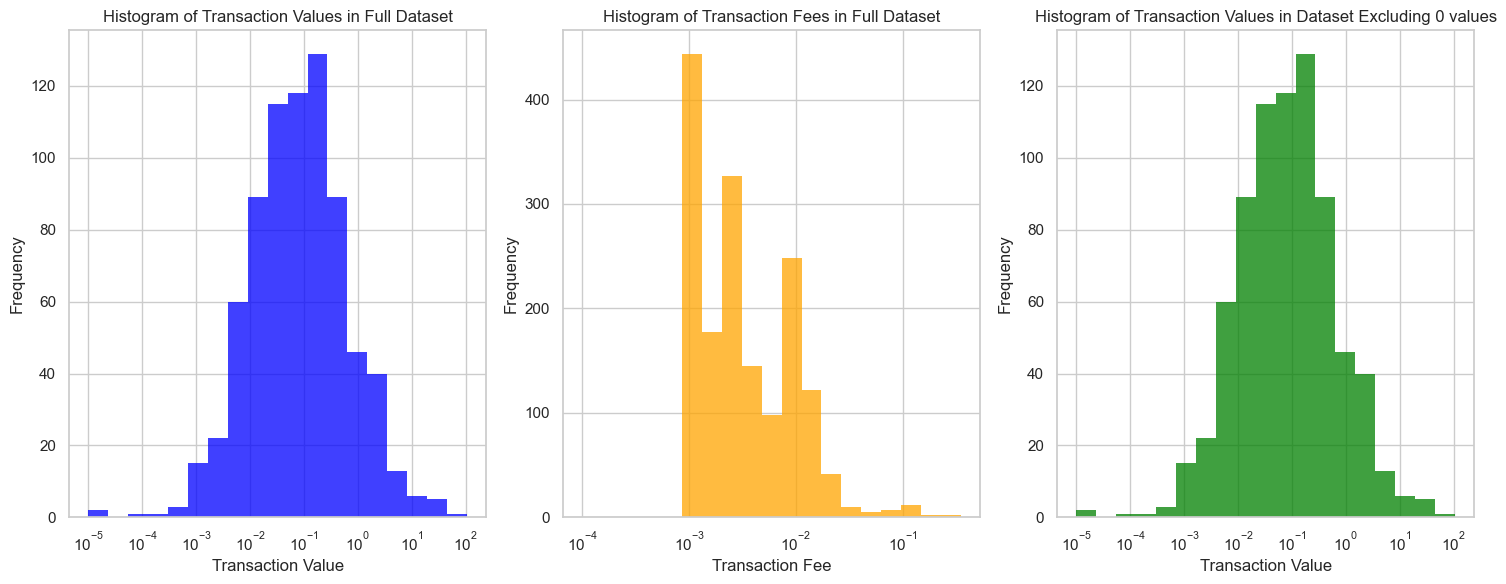

In [18]:
# Set the style for the plot
sns.set(style="whitegrid")

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

# Plot the histogram for 'Value' in full dataset
sns.histplot(data=df, x='Value', bins=np.logspace(np.log10(0.00001), np.log10(df['Value'].max()), 20), color='blue', ax=axes[0])
axes[0].set_xscale('log')
axes[0].set_xlabel('Transaction Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Transaction Values in Full Dataset')

# Plot the histogram for 'Txn_Fee' in full dataset
sns.histplot(data=df, x='Txn_Fee', bins=np.logspace(np.log10(0.0001), np.log10(df['Txn_Fee'].max()), 20), color='orange', ax=axes[1])
axes[1].set_xscale('log')
axes[1].set_xlabel('Transaction Fee')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Transaction Fees in Full Dataset')

# Plot the histogram for 'Value' in dataset excluding 0 values
sns.histplot(data=df_without_zeros, x='Value', bins=np.logspace(np.log10(0.00001), np.log10(df_without_zeros['Value'].max()), 20), color='green', ax=axes[2])
axes[2].set_xscale('log')
axes[2].set_xlabel('Transaction Value')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Histogram of Transaction Values in Dataset Excluding 0 values')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


## Data Sampling and Analysis

In this section, we will delve into the process of data sampling and perform an initial analysis on the transaction data we have collected. Our objective is to understand the distribution of transaction values by sampling the data and comparing the sample statistics with the population statistics.

### Steps

1. **Load the Data**: Import the collected transaction data into a pandas DataFrame.

2. **Data Cleaning**: Clean the data by handling missing values, converting data types, and removing any irrelevant information.

3. **Simple Random Sampling (SRS)**: Create a sample from the dataset using a simple random sampling method. This involves randomly selecting a subset of the data without regard to any specific characteristics of the data.

4. **Stratified Sampling**: Create another sample from the dataset using a stratified sampling method. This involves dividing the data into strata based on a specific characteristic (e.g., transaction value) and then randomly selecting samples from each stratum. Explain what you have stratified the data by and why you chose this column.

5. **Statistical Analysis**: Calculate the mean and standard deviation of the samples and the population. Compare these statistics to understand the distribution of transaction values.

6. **Visualization**: Plot the distribution of transaction values and fees for both the samples and the population to visually compare their distributions.

### Considerations

- **Sample Size**: The size of the sample should be large enough to represent the population accurately but not so large that it becomes impractical to analyze.
- **Sampling Method**: Choose the appropriate sampling method based on the characteristics of the data and the research question.

Explain the above considerations in your report.

In [32]:
import pandas as pd

# Step 1: Load the Data
# Load the CSV file into a DataFrame
df = pd.read_csv('clean_ethereum_transactions_without_zeros.csv')
# Specify the sample size
sample_size = 100  # Adjust this based on your requirement

# Simple Random Sampling
srs_sample = df.sample(n=sample_size, random_state=42)  # Setting random_state for reproducibility

# Specify the sample size for each stratum
stratum_sample_size = 10  # Adjust this based on your requirement

# Split the DataFrame into strata based on 'stratum_column'
strata = [stratum_df for _, stratum_df in df.groupby('Method')]

# Sample from each stratum
stratified_sample = pd.concat([stratum_df.sample(stratum_sample_size, random_state=42) for stratum_df in strata])
print(stratified_sample)

            Value   Txn_Fee        Method
719  1.659590e-01  0.007797       Execute
99   1.800000e+00  0.013794       Execute
49   3.000000e+00  0.007901       Execute
614  3.100000e-01  0.008347       Execute
660  1.400000e-01  0.006907       Execute
451  1.000000e-01  0.007866       Execute
226  1.000000e-01  0.009655       Execute
246  1.100000e-01  0.010219       Execute
651  8.564660e-01  0.003428       Execute
105  1.000000e-02  0.011152       Execute
376  3.270000e-01  0.005901         Other
195  2.442069e-01  0.003710         Other
542  2.528864e-01  0.006316         Other
729  2.300000e-01  0.002772         Other
15   1.300000e-01  0.002736         Other
215  2.500000e-01  0.009846         Other
370  2.300000e-01  0.003371         Other
607  3.100000e-02  0.006407         Other
119  3.000000e-02  0.013982         Other
412  8.955000e-01  0.010158         Other
621  4.000000e-02  0.011350          Swap
389  3.500000e-02  0.009058          Swap
59   5.000000e-01  0.011296       